In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_data = pd.read_csv('train_spam.csv')
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
test_data = pd.read_csv('test_spam.csv')
test_data.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [8]:
train_data.shape, test_data.shape

((16278, 2), (4070, 1))

In [6]:
mylabels = ['ham', 'spam']
mylabels_to_label = {writer: i for i, writer in enumerate(mylabels)}
label_to_mylabels = {i: writer for i, writer in enumerate(mylabels)}

In [7]:
dataset = {}

dataset['train'] = [{'text':text, 'label':mylabels_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['text_type']))]
dataset['test'] = [{'text':text, 'label': 0} \
              for text in np.array(test_data['text'])]

In [9]:
# библиотека для работы со строками. С ее помощью мы удалим знаки препинания
import string
# счетчик для создания счетчика слов
from collections import Counter
# библиотека, с помощью которой разобьем текст на токены
import nltk
from nltk.tokenize import word_tokenize

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')

# функция для обработки предложения
def process_and_tokenize_text(text):
    # приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation)
    )
    # токенизируем текст
    tokens = word_tokenize(prccessed_text)
    return tokens

# массивы для хранения токенизированных тренировочных и тестовых данных
train_data = []
test_data = []

# пустой счетчик слов
words = Counter()

# проходимся по текстам обучающего датасета и предобрабатываем их
for example in tqdm_notebook(dataset['train']):
    text = example['text']
    label = example['label']
    text_processed = process_and_tokenize_text(text)
    train_data.append((text_processed, label))

    # увеличиваем счетчик каждого слова в словаре
    for word in text_processed:
        words[word] += 1

# проходимся по текстам тестового датасета и предобрабатываем их
for example in tqdm_notebook(dataset['test']):
    text = example['text']
    label = example['label']
    text_processed = process_and_tokenize_text(text)
    test_data.append((text_processed, label))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-9-ccb0c4e80201>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['train']):


  0%|          | 0/16278 [00:00<?, ?it/s]

<ipython-input-9-ccb0c4e80201>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['test']):


  0%|          | 0/4070 [00:00<?, ?it/s]

In [10]:
# создаем словарь как множество слов
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# будем добавлять в словарь только те слова, которые
# встречались в обучающих данных не менее 25 раз
counter_threshold = 25

# пополняем словарь словами из words
for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [11]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

(array([3.920e+02, 6.390e+02, 1.044e+03, 9.090e+02, 6.820e+02, 5.480e+02,
        4.800e+02, 3.750e+02, 3.990e+02, 3.930e+02, 4.810e+02, 4.880e+02,
        5.270e+02, 4.590e+02, 3.360e+02, 2.750e+02, 2.290e+02, 1.590e+02,
        1.670e+02, 7.300e+01, 1.320e+02, 1.260e+02, 1.090e+02, 1.250e+02,
        1.120e+02, 1.150e+02, 1.050e+02, 1.100e+02, 8.700e+01, 9.500e+01,
        9.100e+01, 9.600e+01, 7.400e+01, 8.200e+01, 1.140e+02, 8.800e+01,
        7.800e+01, 8.600e+01, 5.800e+01, 2.900e+01, 8.700e+01, 7.900e+01,
        1.050e+02, 7.400e+01, 6.600e+01, 6.300e+01, 6.200e+01, 7.600e+01,
        6.600e+01, 8.100e+01, 5.100e+01, 5.800e+01, 5.900e+01, 6.000e+01,
        7.900e+01, 6.900e+01, 6.200e+01, 7.500e+01, 7.900e+01, 5.000e+01,
        1.050e+02, 1.180e+02, 1.860e+02, 2.050e+02, 2.030e+02, 2.560e+02,
        2.370e+02, 2.470e+02, 2.460e+02, 3.020e+02, 2.560e+02, 2.600e+02,
        2.560e+02, 2.140e+02, 1.880e+02, 1.790e+02, 1.180e+02, 1.070e+02,
        6.100e+01, 3.200e+01, 5.400e+0

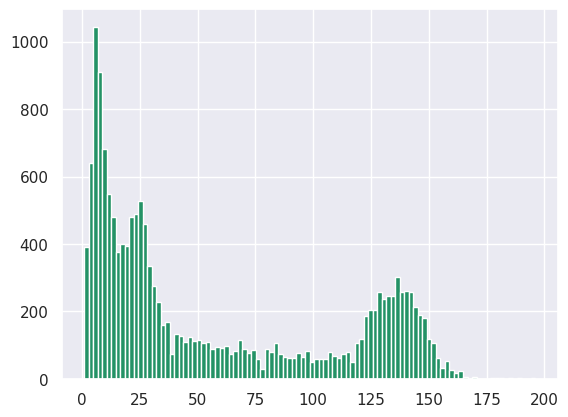

In [12]:
plt.hist([len(x[0]) for x in train_data], bins=100)

In [13]:
def collate_fn_with_padding(input_batch, max_len=256):
    # input_batch — батч пар (токенизированный текст, label)
    texts = [x[0] for x in input_batch]
    labels = [x[1] for x in input_batch]
    # для каждого элемента батча получаем длину токенизированного текста в токенах
    seq_lens = [len(x) for x in texts]
    # определяем максимальную длину элементов в текущем батче
    max_seq_len = min(max(seq_lens), max_len)

    # проходимся по элементам батча и заменяем токены на их индексы из словаря
    # также последовательности короче max_seq_len дополняем токенами <pad>
    processed_texts = []
    for text, label in zip(texts, labels):
        text = text[:max_seq_len]
        text = [word2ind[x] if x in vocab else word2ind['<unk>'] for x in text]
        for _ in range(max_seq_len - len(text)):
            text.append(word2ind['<pad>'])

        processed_texts.append(text)

    # переводим элементы батча в форматы тензоров
    processed_texts = torch.LongTensor(processed_texts).to(device)
    labels = torch.LongTensor(labels).to(device)

    processed_batch = {
        'input_ids': processed_texts,
        'label': labels
    }

    return processed_batch

In [23]:
# поделим тестовые данные на val и test
np.random.seed(42)
val_indices = np.random.choice(np.arange(len(train_data)), 1000)
train_indices = [x for x in range(len(train_data)) if x not in val_indices]
val_data = [train_data[i] for i in val_indices]
train_data = [train_data[i] for i in train_indices]

# заводим даталоадеры
batch_size = 128
train_dataloader = DataLoader(
    train_data, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [24]:
class SimpleRNN(nn.Module):
    def __init__(
        self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'last'
        ):
        super().__init__()
        # слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # рекуррентный слой
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # два полносвязных слоя
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # слой дропаут
        self.dropout = nn.Dropout(p=0.01)

        # каким образом выходы RNN-слоя для разных моментов времени будут
        # агрегироваться перед подачей дальше на вход полносвязному слою
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)          # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]         #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:, -1, :]
        else:
            raise ValueError("Invalid aggregation_type")

        output = F.tanh(output)
        output = F.tanh(self.dropout(self.fc1(output)))   # [batch_size, hidden_dim]
        output = self.fc2(output)                         # [batch_size, num_classes]

        return output

In [25]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            print(logits)
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()

    return predictions

In [26]:
def evaluate(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [27]:
def train(model, optimizer, criterion, num_epoch=5, eval_steps=100):

    losses = []
    accs_train = []
    accs_val = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm_notebook(train_dataloader,
                                                desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                accs_train.append(evaluate(model, train_dataloader))
                accs_val.append(evaluate(model, val_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, accs_train, accs_val

In [28]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2

losses_type = {}
accs_train_type = {}
accs_val_type = {}

for aggregation_type in ['max']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = SimpleRNN(hidden_dim=300,
                      vocab_size=len(vocab),
                      num_classes=8,
                      aggregation_type=aggregation_type
                      ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses, accs_train, accs_val = train(model,
                                         optimizer,
                                         criterion,
                                         num_epoch=10,
                                         eval_steps=len(train_dataloader) // 2)

    losses_type[aggregation_type] = losses
    accs_train_type[aggregation_type] = accs_train
    accs_val_type[aggregation_type] = accs_val

Starting training for max


<ipython-input-27-48d3f6fda81d>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader,


Training epoch 0::   0%|          | 0/119 [00:00<?, ?it/s]

<ipython-input-26-fa459c92f69e>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

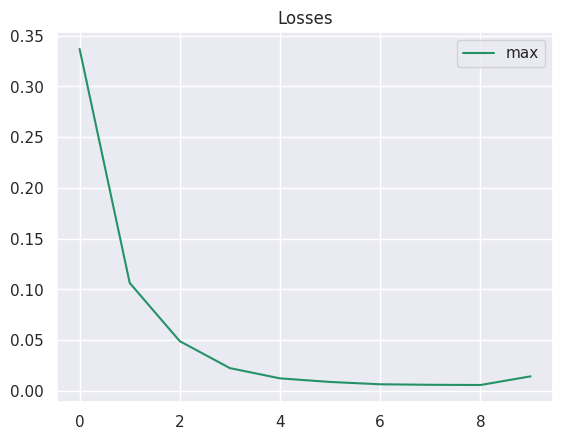

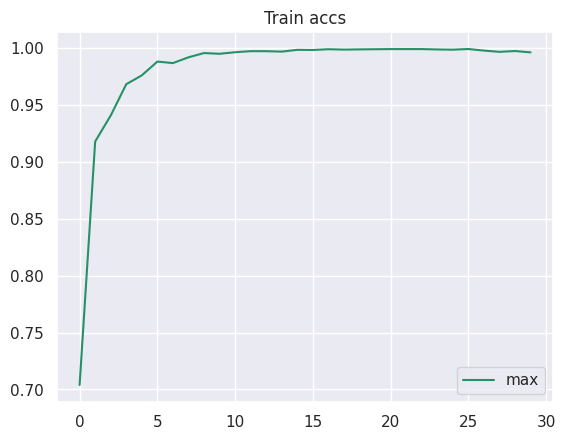

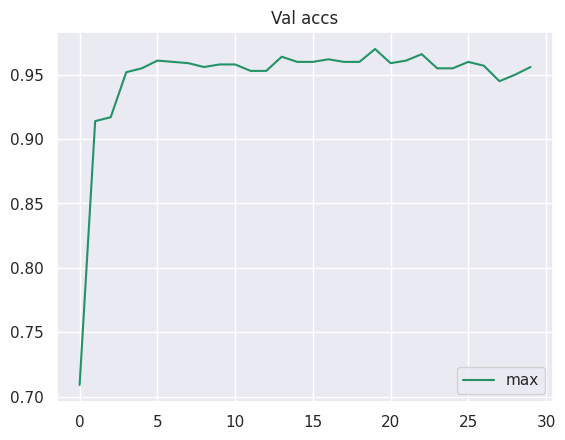

In [29]:
for aggregation_type in ['max']:
    plt.plot(losses_type[aggregation_type])
plt.title('Losses')
plt.legend(['max'])
plt.show()

for aggregation_type in ['max']:
    plt.plot(accs_train_type[aggregation_type])
plt.title('Train accs')
plt.legend(['max'])
plt.show()

for aggregation_type in ['max']:
    plt.plot(accs_val_type[aggregation_type])
plt.title('Val accs')
plt.legend(['max'])
plt.show()

In [32]:
accs_val_type['max'][-1]

0.956000030040741

In [ ]:
# сделаем кроссвалидацию 
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accs = []

for train_indices, val_indices in kf.split(train_data):
    val_data = [train_data[i] for i in val_indices]
    train_data_cv = [train_data[i] for i in train_indices]

    train_dataloader = DataLoader(
        train_data_cv, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

    val_dataloader = DataLoader(
        val_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

    model = SimpleRNN(hidden_dim=300,
                      vocab_size=len(vocab),
                      num_classes=8,
                      aggregation_type='max'
                      ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses, accs_train, accs_val = train(model,
                                         optimizer,
                                         criterion,
                                         num_epoch=10,
                                         eval_steps=len(train_dataloader) // 2)

    accs.append(accs_val[-1])


In [ ]:
np.mean(accs)

In [ ]:
# запишем предсказания в файл
predictions = get_predictions(model, test_dataloader)
predictions = [label_to_mylabels[label] for label in predictions]

test_data = pd.read_csv('test_spam.csv')
test_data['score'] = predictions
test_data.to_csv('submission_RNN.csv', index=False)